In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from calcwf import gen_wf, shifted_f, shifted_e, chirp2total, total2chirp, match_h1_h2, get_h, match_wfs, match_true_anomaly, match_hn

# Shifted frequency plot functions

In [2]:
# Calculates match over range of intial frequency values
def s_f_h(fiducials, e_M, s_f_len, f_low, approximant='TEOBResumS', subsample_interpolation=True):

    # Generate fiducial waveform and data dictionary
    _, h1, h2, h_ap, h_peri = get_h([1,1], f_low, *fiducials, sample_rate,
                                    approximant=approximant, subsample_interpolation=subsample_interpolation)
    data = {}
    gridsize = s_f_len
    progress = 0
    e, M = e_M
    
    # Creates grid dimension of shifted frequency
    max_s_f = shifted_f(f_low, e, M, fiducials[2])
    s_f_vals = np.linspace(f_low, max_s_f, s_f_len, endpoint=True)
    s_e_vals = shifted_e(s_f_vals, f_low, e)
    s_f_matches_1 = []
    s_f_matches_2 = []

    # Loops over each initial frequency
    for s_f, s_e in zip(s_f_vals, s_e_vals):

        # Create waveform to match
        s = gen_wf(s_f, s_e, M, fiducials[2], sample_rate, approximant)

        # Calculate matches to h1 and h2
        match_h1, match_h2 = match_h1_h2(h1, h2, s, f_low)
        s_f_matches_1.append(abs(match_h1))
        s_f_matches_2.append(abs(match_h2))

        # Progress bar
        progress += 1
        print('\r' + f'{progress} done out of {gridsize}', end='')

    # Calculate total quad match of h1 and h2
    s_f_matches_quad = np.sqrt(np.array(s_f_matches_1)**2+np.array(s_f_matches_2)**2)

    # Saves data
    data['h1'] = s_f_matches_1
    data['h2'] = s_f_matches_2
    data['h_quad'] = s_f_matches_quad
    data['s_f_vals'] = s_f_vals
    data['s_e_vals'] = s_e_vals

    # Calculate phase of matches
    s = gen_wf(f_low, e, M, fiducials[2], sample_rate, approximant)
    match_h1, match_h2 = match_h1_h2(h1, h2, s, f_low)
    data['h1_phase'] = np.angle(match_h1)
    data['h2_phase'] = np.angle(match_h2)

    return data

In [3]:
# Calculates match over range of intial frequency values
def s_f_h1_h2(fiducials, e_M, s_f_len, f_low, approximant='TEOBResumS', subsample_interpolation=True):

    # Generate fiducial waveform and data dictionary
    s = gen_wf(f_low, *fiducials, sample_rate, approximant)
    data = {}
    gridsize = s_f_len
    progress = 0
    e, M = e_M
    
    # Creates grid dimension of shifted frequency
    max_s_f = shifted_f(f_low, e, M, fiducials[2])
    s_f_vals = np.linspace(f_low, max_s_f, s_f_len, endpoint=True)
    s_e_vals = shifted_e(s_f_vals, f_low, e)
    s_f_matches_1 = []
    s_f_matches_2 = []

    # Loops over each initial frequency
    for s_f, s_e in zip(s_f_vals, s_e_vals):

        # Create waveform to match
        _, h1, h2, _, _ = get_h([1,1], s_f, s_e, M, fiducials[2], sample_rate,
                                approximant=approximant, subsample_interpolation=subsample_interpolation)

        # Calculate matches to h1 and h2
        match_h1, match_h2 = match_h1_h2(h1, h2, s, f_low)
        s_f_matches_1.append(abs(match_h1))
        s_f_matches_2.append(abs(match_h2))

        # Progress bar
        progress += 1
        print('\r' + f'{progress} done out of {gridsize}', end='')

    # Calculate total quad match of h1 and h2
    s_f_matches_quad = np.sqrt(np.array(s_f_matches_1)**2+np.array(s_f_matches_2)**2)

    # Saves data
    data['h1'] = s_f_matches_1
    data['h2'] = s_f_matches_2
    data['h_quad'] = s_f_matches_quad
    data['s_f_vals'] = s_f_vals
    data['s_e_vals'] = s_e_vals

    # Calculate phase of matches
    _, h1, h2, _, _ = get_h([1,1], f_low, e, M, fiducials[2], sample_rate,
                            approximant=approximant, subsample_interpolation=subsample_interpolation)
    match_h1, match_h2 = match_h1_h2(h1, h2, s, f_low)
    data['h1_phase'] = np.angle(match_h1)
    data['h2_phase'] = np.angle(match_h2)

    return data

In [38]:
# Makes plot of quad match data
def plot_s_f(fiducials, e_M, data, f_low, approximant='TEOBResumS', ylims=(0.9,1.01), phase_lines=True):

    # Intialise plot
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()
        
    # Makes plot
    e, M = e_M
    ax1.plot(data['s_f_vals'], data['h1'], ls='dashed', c=f'C0', label=f'h1 $e={e}$, $M={M}~M_\odot$')
    ax1.plot(data['s_f_vals'], data['h2'], ls='dotted', c=f'C0', label=f'h2 $e={e}$, $M={M}~M_\odot$')
    ax1.plot(data['s_f_vals'], data['h_quad'], ls='solid', c=f'C0', label=f'quad $e={e}$, $M={M}~M_\odot$')
    ax1.set_xlabel('Shifted frequency')
    ax2.plot(data['s_e_vals'], data['h1'], alpha=0)
    ax2.invert_xaxis()
    ax2.set_xlabel('Shifted eccentricity')

    # Calculate phase shifts
    s_f_range = f_low - np.min(data['s_f_vals'])
    h1_phase_f = (data['h1_phase']/(2*np.pi))*s_f_range
    h2_phase_f = (data['h2_phase']/(2*np.pi))*s_f_range

    # Plots phase lines if requested
    if phase_lines:

        # Which lines to plot
        phase_lines = ['-h1', '-h2', '+h1', '+h2', '-h1,-h2', '+h1,+h2', '-h1,+h2', '+h1,-h2']
    
        # Loops over each phase line
        for i, line in enumerate(phase_lines):
    
            # Calculates x_position of phase line
            shifts = line.split(',')
            x_pos = f_low
            for shift in shifts:
                if shift == '-h1':
                    x_pos -= h1_phase_f
                elif shift == '-h2':
                    x_pos -= h2_phase_f
                elif shift == '+h1':
                    x_pos += h1_phase_f
                elif shift == '+h2':
                    x_pos += h2_phase_f
    
            # Cycles x position by 2pi if not on plot
            if x_pos > f_low:
                x_pos -= s_f_range
            elif x_pos < data['s_f_vals'][-1]:
                x_pos += s_f_range
    
            # Plot line
            ax1.axvline(x_pos, label=line, c=f'C{i+1}')
            
    # Finish plot
    ax1.axhline(1, c='k', ls='dashed')
    ax1.legend(loc=(1,0))
    ax1.set_ylabel('Match')
    ax1.set_title(f'Fiducial waveform of $e={fiducials[0]}$ at $f={f_low}~Hz$, $M={fiducials[1]}~M_\odot$, {approximant}')
    ax1.set_ylim(ylims)

# Test shifted frequency plots

In [41]:
# Shifting h
start = time.time()
sample_rate = 4096
dataslot_A = s_f_h([0.1, chirp2total(24, 2), 2], (0.1, chirp2total(24, 2)), 21, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

21 done out of 21
Time taken: 38.006532430648804 seconds


In [42]:
# Shifting h1, h2
start = time.time()
sample_rate = 4096
dataslot_B = s_f_h1_h2([0.1, chirp2total(24, 2), 2], (0.1, chirp2total(24, 2)), 21, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

21 done out of 21
Time taken: 99.94217014312744 seconds


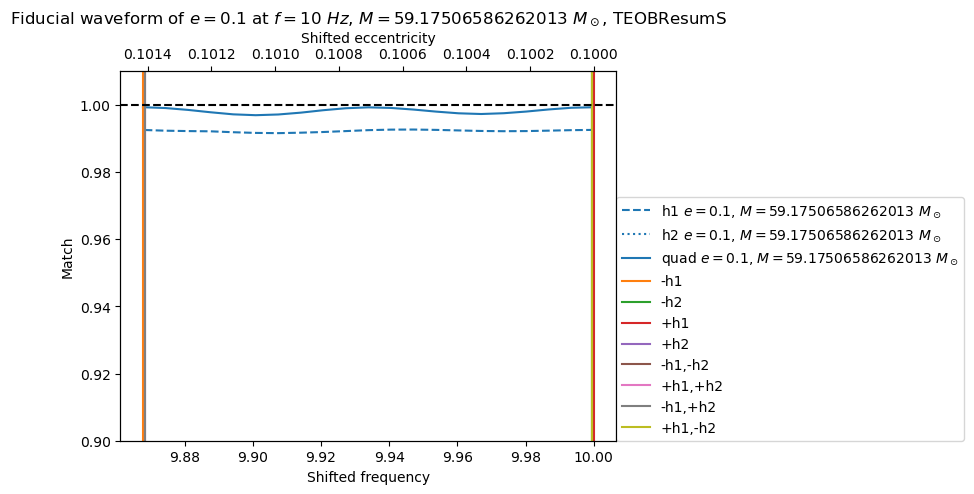

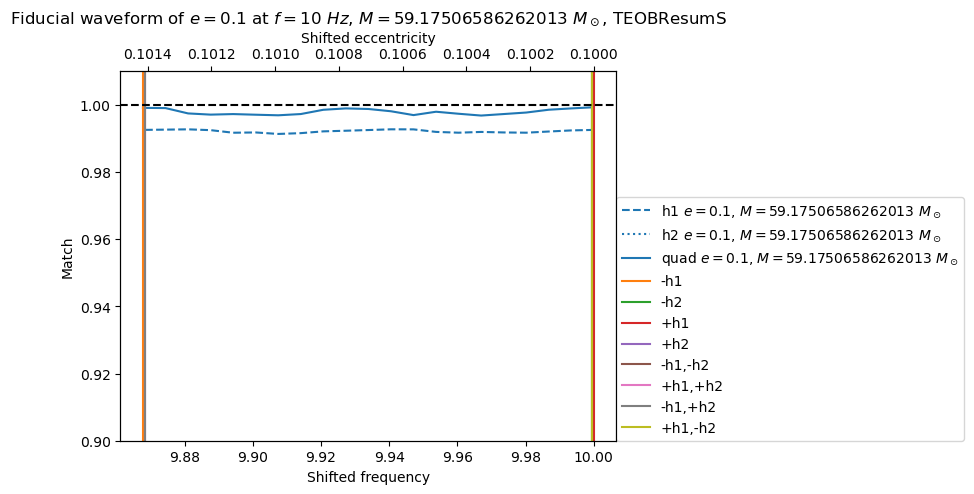

In [43]:
plot_s_f([0.1, chirp2total(24, 2), 2], (0.1, chirp2total(24, 2)), dataslot_A, 10) # Plot shifting h
plot_s_f([0.1, chirp2total(24, 2), 2], (0.1, chirp2total(24, 2)), dataslot_B, 10) # Plot shifting h1, h2

In [9]:
# Shifting h
start = time.time()
sample_rate = 4096
dataslot_0 = s_f_h([0.1, chirp2total(24, 2), 2], (0.12, chirp2total(23.75, 2)), 51, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 86.84296894073486 seconds


In [10]:
# Shifting h1, h2
start = time.time()
sample_rate = 4096
dataslot_1 = s_f_h1_h2([0.1, chirp2total(24, 2), 2], (0.12, chirp2total(23.75, 2)), 51, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 243.86490392684937 seconds


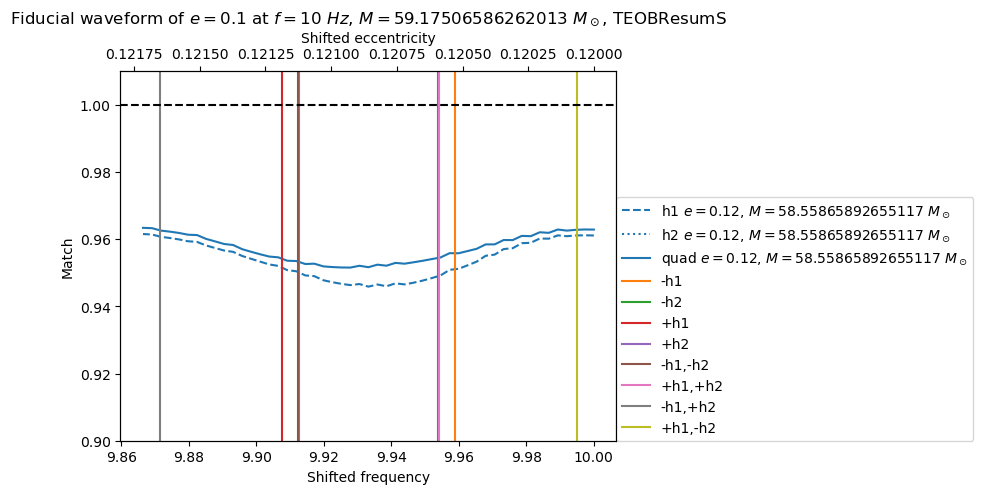

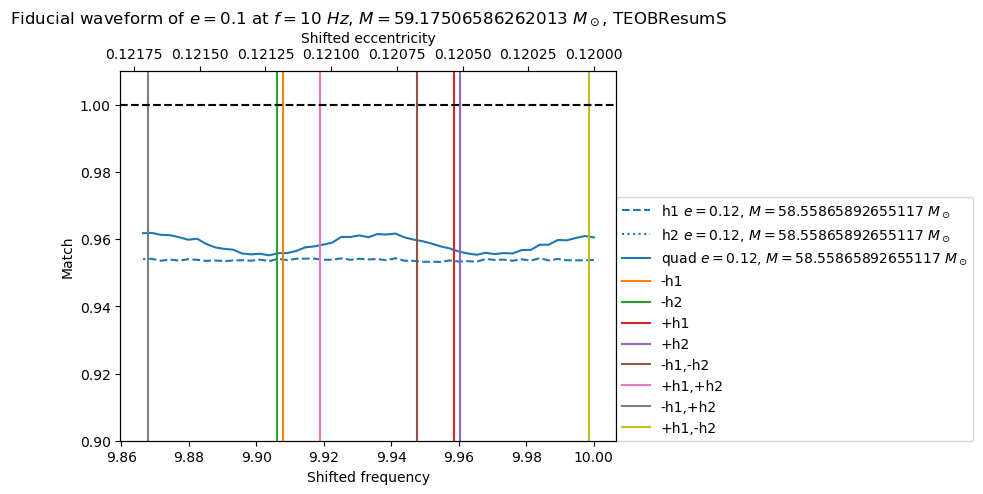

In [11]:
plot_s_f([0.1, chirp2total(24, 2), 2], (0.12, chirp2total(23.75, 2)), dataslot_0, 10) # Plot shifting h
plot_s_f([0.1, chirp2total(24, 2), 2], (0.12, chirp2total(23.75, 2)), dataslot_1, 10) # Plot shifting h1, h2

In [12]:
# Shifting h
start = time.time()
sample_rate = 4096
dataslot_2 = s_f_h([0.1, chirp2total(24, 2), 2], (0.1, chirp2total(23.75, 2)), 51, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 86.5052056312561 seconds


In [13]:
# Shifting h1, h2
start = time.time()
sample_rate = 4096
dataslot_3 = s_f_h1_h2([0.1, chirp2total(24, 2), 2], (0.1, chirp2total(23.75, 2)), 51, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 242.52162504196167 seconds


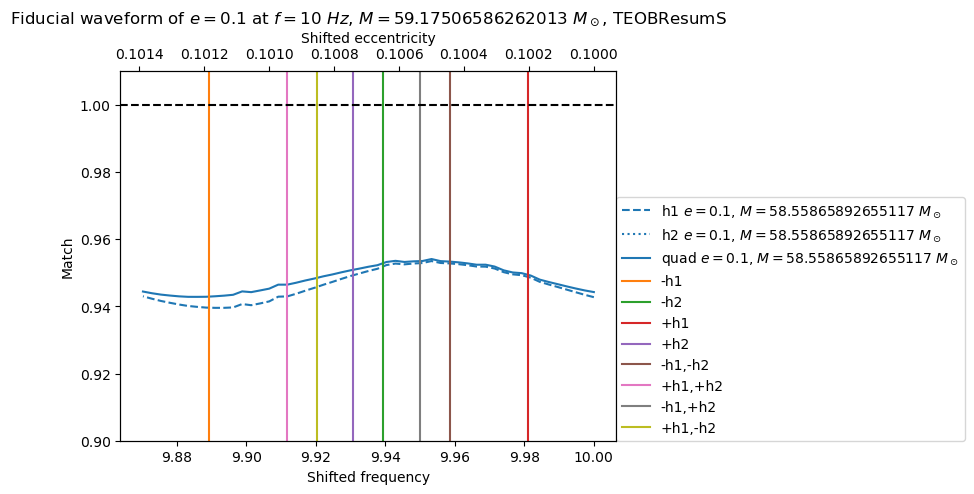

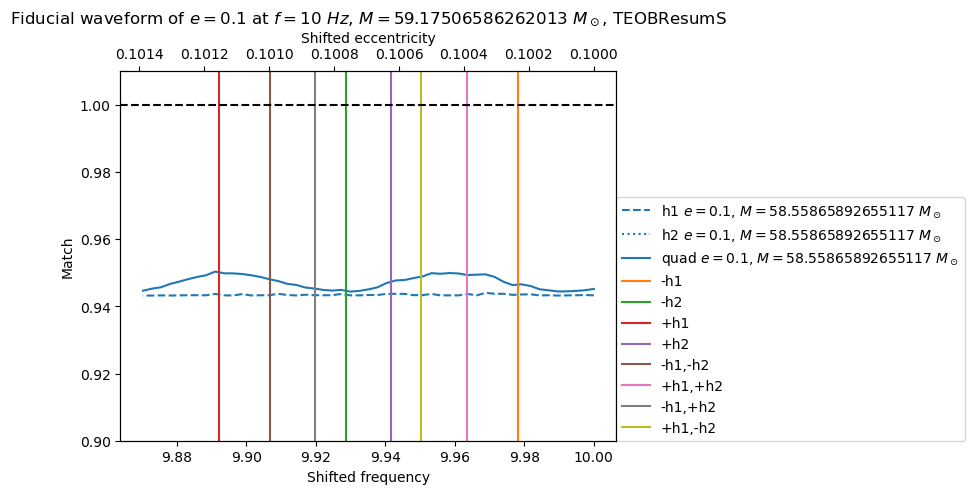

In [14]:
plot_s_f([0.1, chirp2total(24, 2), 2], (0.1, chirp2total(23.75, 2)), dataslot_2, 10) # Plot shifting h
plot_s_f([0.1, chirp2total(24, 2), 2], (0.1, chirp2total(23.75, 2)), dataslot_3, 10) # Plot shifting h1, h2

# Test waveform plots

Match is 0.9610770727467737
Shifted match is 0.9537937666624599


(-2.2e-19, 2.2e-19)

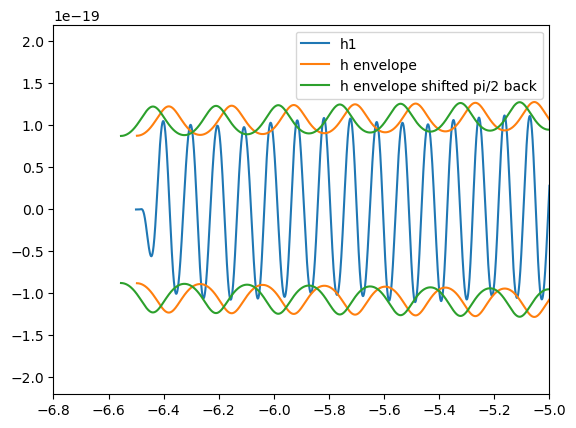

In [42]:
# Shifting h example

# Creating waveforms
_, h1, h2, _, _ = get_h([1,1], 10, *[0.1, chirp2total(24, 2), 2], 4096,
                        approximant='TEOBResumS', subsample_interpolation=True)
s = gen_wf(10, 0.12, chirp2total(23.75, 2), 2, 4096, 'TEOBResumS')
s_f = 10 - (10 - shifted_f(10, 0.12, chirp2total(23.75, 2), 2))/4 # Shift pi/2 back
s_e = shifted_e(s_f, 10, 0.12)
s_s_f = gen_wf(s_f, s_e, chirp2total(23.75, 2), 2, 4096, 'TEOBResumS')

# Match waveforms
m1 = match_wfs(h1, s, 10, True)
print(f'Match is {m1}')
m1 = match_wfs(h1, s_s_f, 10, True)
print(f'Shifted match is {m1}')

# Plotting waveforms
plt.plot(h1.sample_times, h1, c='C0', label='h1')
plt.plot(s.sample_times, np.sqrt(s.real()**2+s.imag()**2), c='C1', label='h envelope')
plt.plot(s.sample_times, -np.sqrt(s.real()**2+s.imag()**2), c='C1')
plt.plot(s_s_f.sample_times, np.sqrt(s_s_f.real()**2+s_s_f.imag()**2), c='C2', label='h envelope shifted pi/2 back')
plt.plot(s_s_f.sample_times, -np.sqrt(s_s_f.real()**2+s_s_f.imag()**2), c='C2')
plt.legend()
plt.xlim(-6.8,-5)
plt.ylim(-2.2e-19,2.2e-19)

Match is 0.9538065155919585
Shifted match is 0.9536653707490069


(-2.2e-19, 2.2e-19)

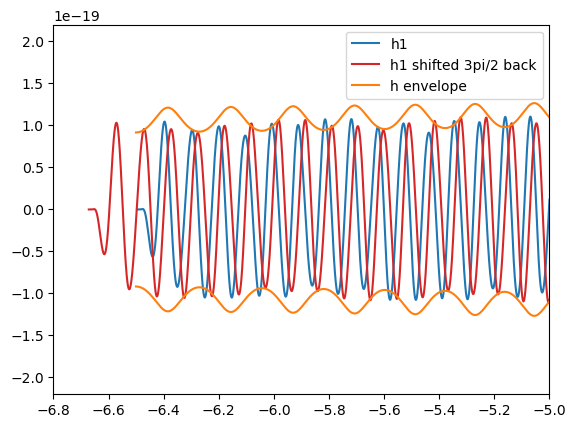

In [41]:
# Shifting h1 h2 example

# Creating waveforms
s = gen_wf(10, 0.1, chirp2total(24, 2), 2, 4096, 'TEOBResumS')
_, h1, h2, _, _ = get_h([1,1], 10, *[0.12, chirp2total(23.75, 2), 2], 4096,
                        approximant='TEOBResumS', subsample_interpolation=True)
s_f = 10 - 3*(10 - shifted_f(10, 0.12, chirp2total(23.75, 2), 2))/4 # Shift 3pi/2 back - should be equivalent to above?
s_e = shifted_e(s_f, 10, 0.12)
_, h1_s_f, h2_s_f, _, _ = get_h([1,1], s_f, *[s_e, chirp2total(23.75, 2), 2], 4096,
                                approximant='TEOBResumS', subsample_interpolation=True)

# Match waveforms
m1 = match_wfs(h1, s, 10, True)
print(f'Match is {m1}')
m1 = match_wfs(h1_s_f, s, 10, True)
print(f'Shifted match is {m1}')

# Plotting waveforms
plt.plot(h1.sample_times, h1, c='C0', label='h1')
plt.plot(h1_s_f.sample_times, h1_s_f, c='C3', label='h1 shifted 3pi/2 back')
plt.plot(s.sample_times, np.sqrt(s.real()**2+s.imag()**2), c='C1', label='h envelope')
plt.plot(s.sample_times, -np.sqrt(s.real()**2+s.imag()**2), c='C1')
plt.legend()
plt.xlim(-6.8,-5)
plt.ylim(-2.2e-19,2.2e-19)

# Shifted frequency with standard TEOBResumS waveforms

In [5]:
# Calculates match over range of intial frequency values
def s_f_teob(fiducials, e_M, s_f_len, f_low, approximant='TEOBResumS', subsample_interpolation=True):

    # Generate fiducial waveform and data dictionary
    s = gen_wf(f_low, *fiducials, sample_rate, approximant)
    data = {}
    gridsize = s_f_len
    progress = 0
    e, M = e_M
    
    # Creates grid dimension of shifted frequency
    max_s_f = shifted_f(f_low, e, M, fiducials[2])
    s_f_vals = np.linspace(f_low, max_s_f, s_f_len, endpoint=True)
    s_e_vals = shifted_e(s_f_vals, f_low, e)
    s_f_matches = []

    # Loops over each initial frequency
    for s_f, s_e in zip(s_f_vals, s_e_vals):

        # Create waveform to match
        s_trial = gen_wf(s_f, s_e, M, fiducials[2], sample_rate, approximant)

        # Calculate matches to h1 and h2
        m = match_wfs(s, s_trial, f_low, True)
        s_f_matches.append(m)

        # Progress bar
        progress += 1
        print('\r' + f'{progress} done out of {gridsize}', end='')

    # Saves data
    data['matches'] = s_f_matches
    data['s_f_vals'] = s_f_vals
    data['s_e_vals'] = s_e_vals

    # Calculate phase of matches
    _, h1, h2, _, _ = get_h([1,1], f_low, e, M, fiducials[2], sample_rate,
                            approximant=approximant, subsample_interpolation=subsample_interpolation)
    match_h1, match_h2 = match_h1_h2(h1, h2, s, f_low)
    data['h1_phase'] = np.angle(match_h1)
    data['h2_phase'] = np.angle(match_h2)

    return data

In [11]:
# Makes plot of quad match data
def plot_s_f_teob(fiducials, e_M, data, f_low, approximant='TEOBResumS', ylims=(0.9,1.01), found_match=None):

    # Intialise plot
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()
        
    # Makes plot
    e, M = e_M
    ax1.plot(data['s_f_vals'], data['matches'], ls='solid', c=f'C0', label=f'Match to $e={e}$, $M={M}~M_\odot$')
    ax1.set_xlabel('Shifted frequency')
    ax2.plot(data['s_e_vals'], data['matches'], alpha=0)
    ax2.invert_xaxis()
    ax2.set_xlabel('Shifted eccentricity')

    # Calculate phase shifts
    s_f_range = f_low - np.min(data['s_f_vals'])
    h1_phase_f = (data['h1_phase']/(2*np.pi))*s_f_range
    h2_phase_f = (data['h2_phase']/(2*np.pi))*s_f_range

    # Which lines to plot
    phase_lines = ['-h1', '-h2', '+h1', '+h2', '-h1,-h2', '+h1,+h2', '-h1,+h2', '+h1,-h2']

    # Loops over each phase line
    for i, line in enumerate(phase_lines):

        # Calculates x_position of phase line
        shifts = line.split(',')
        x_pos = f_low
        for shift in shifts:
            if shift == '-h1':
                x_pos -= h1_phase_f
            elif shift == '-h2':
                x_pos -= h2_phase_f
            elif shift == '+h1':
                x_pos += h1_phase_f
            elif shift == '+h2':
                x_pos += h2_phase_f

        # Cycles x position by 2pi if not on plot
        if x_pos > f_low:
            x_pos -= s_f_range
        elif x_pos < data['s_f_vals'][-1]:
            x_pos += s_f_range

        # Plot line
        ax1.axvline(x_pos, label=line, c=f'C{i+1}')

    # Plots match found if provided
    if found_match is not None:
        ax1.axhline(np.abs(found_match), ls='dashed', c=f'C{i+2}', label='Found with match_true_anomaly()')
        
    # Finish plot
    ax1.axhline(1, c='k', ls='dashed')
    ax1.legend(loc=(1,0))
    ax1.set_ylabel('Match')
    ax1.set_title(f'Fiducial waveform of $e={fiducials[0]}$ at $f={f_low}~Hz$, $M={fiducials[1]}~M_\odot$, {approximant}')
    ax1.set_ylim(ylims)

In [7]:
# Shifting teob wfs
start = time.time()
sample_rate = 4096
dataslot_4 = s_f_teob([0.1, chirp2total(24, 2), 2], (0.12, chirp2total(23.75, 2)), 51, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 78.11769104003906 seconds


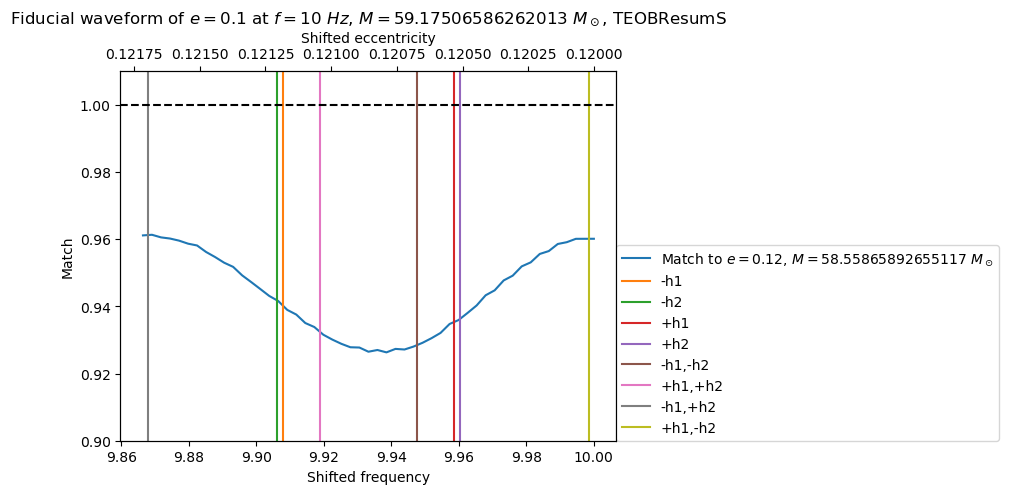

In [7]:
plot_s_f_teob([0.1, chirp2total(24, 2), 2], (0.12, chirp2total(23.75, 2)), dataslot_4, 10)

In [14]:
# Shifting teob wfs
start = time.time()
sample_rate = 4096
dataslot_5 = s_f_teob([0.1, chirp2total(24, 2), 2], (0.1, chirp2total(23.75, 2)), 51, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 77.50184631347656 seconds


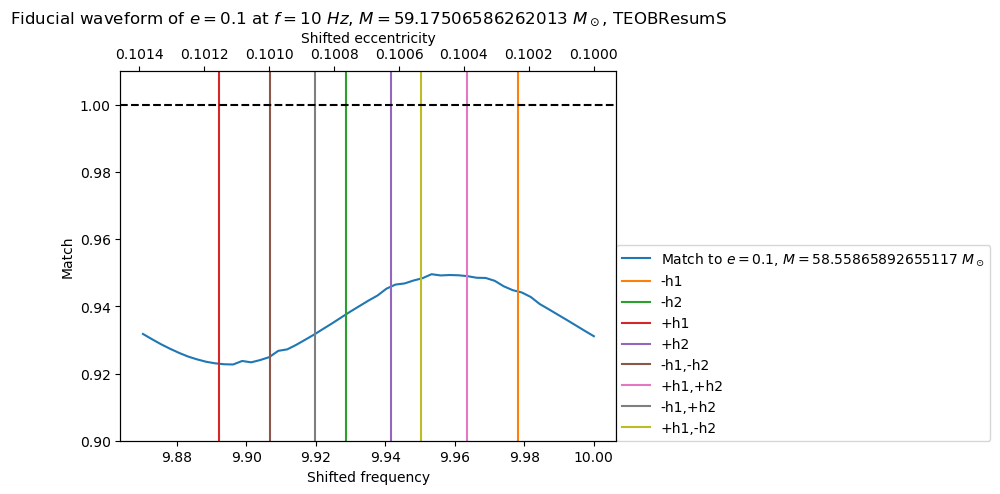

In [54]:
plot_s_f_teob([0.1, chirp2total(24, 2), 2], (0.1, chirp2total(23.75, 2)), dataslot_5, 10)

In [16]:
# Shifting teob wfs
start = time.time()
sample_rate = 4096
dataslot_6 = s_f_teob([0.1, chirp2total(24, 2), 2], (0.15, chirp2total(23.75, 2)), 51, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 78.72278094291687 seconds


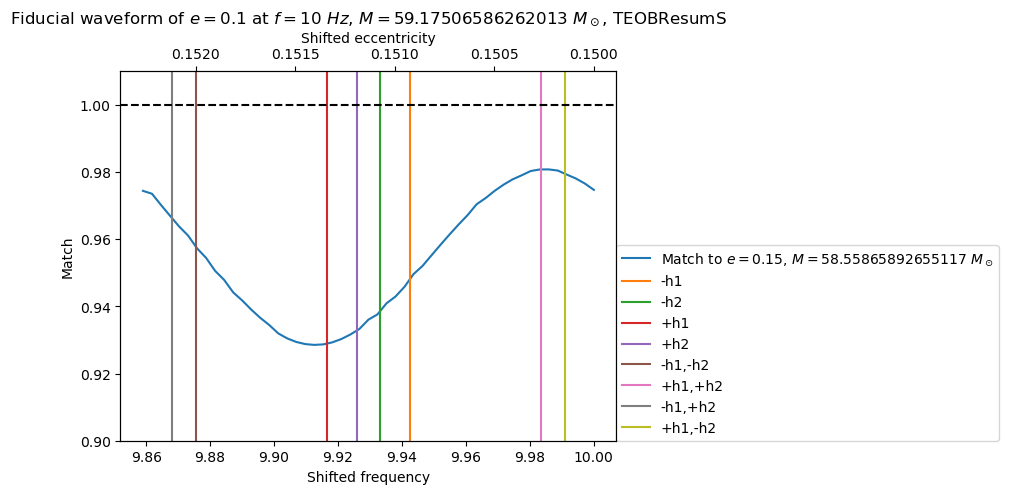

In [57]:
plot_s_f_teob([0.1, chirp2total(24, 2), 2], (0.15, chirp2total(23.75, 2)), dataslot_6, 10)

In [18]:
# Shifting teob wfs
start = time.time()
sample_rate = 4096
dataslot_7 = s_f_teob([0.1, chirp2total(24, 2), 2], (0.1, chirp2total(24, 2)), 51, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 75.91480088233948 seconds


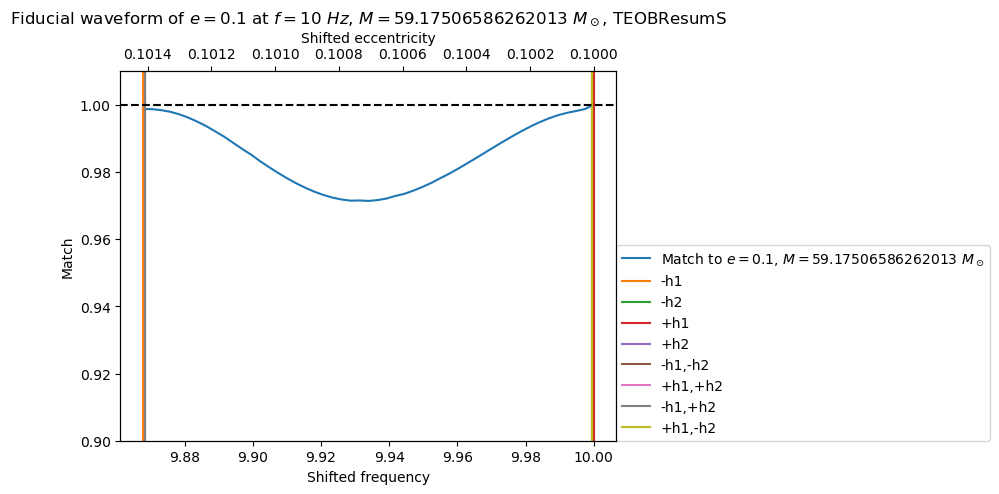

In [60]:
plot_s_f_teob([0.1, chirp2total(24, 2), 2], (0.1, chirp2total(24, 2)), dataslot_7, 10)

In [20]:
# Shifting teob wfs
start = time.time()
sample_rate = 4096
dataslot_8 = s_f_teob([0.1, chirp2total(24, 2), 2], (0.1, chirp2total(24.5, 2)), 51, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 73.25676083564758 seconds


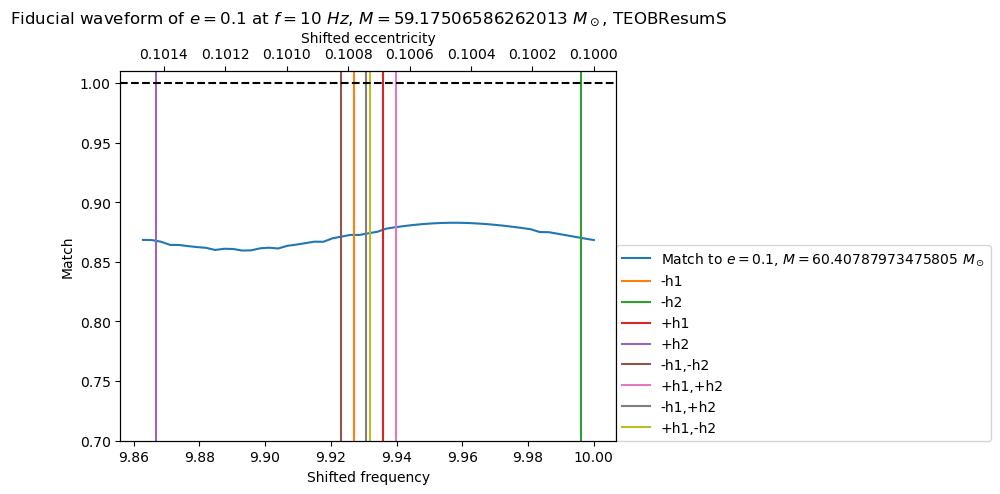

In [63]:
plot_s_f_teob([0.1, chirp2total(24, 2), 2], (0.1, chirp2total(24.5, 2)), dataslot_8, 10, ylims=(0.7,1.01))

In [25]:
# Shifting teob wfs
start = time.time()
sample_rate = 4096
dataslot_9 = s_f_teob([0.1, chirp2total(24, 2), 2], (0, chirp2total(24, 2)), 51, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 9.234897136688232 seconds


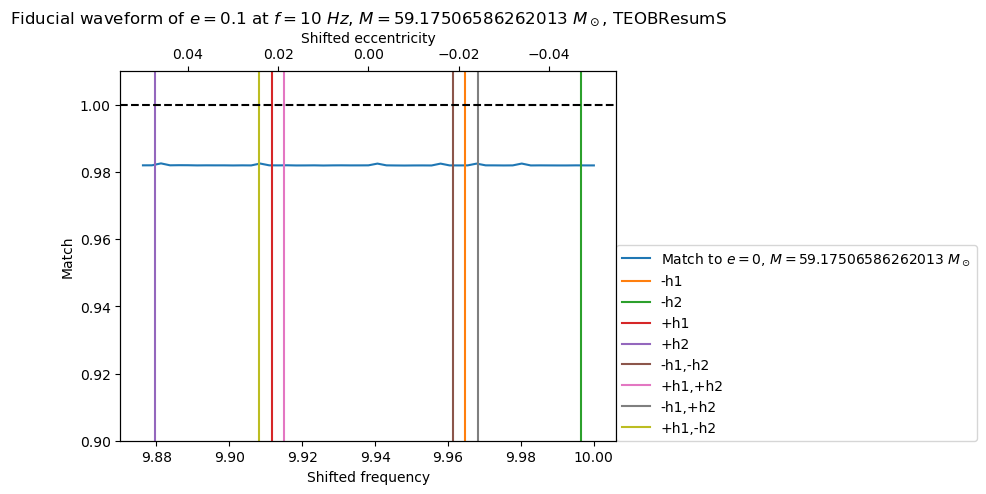

In [26]:
plot_s_f_teob([0.1, chirp2total(24, 2), 2], (0, chirp2total(24, 2)), dataslot_9, 10)

# Testing match_true_anomaly()

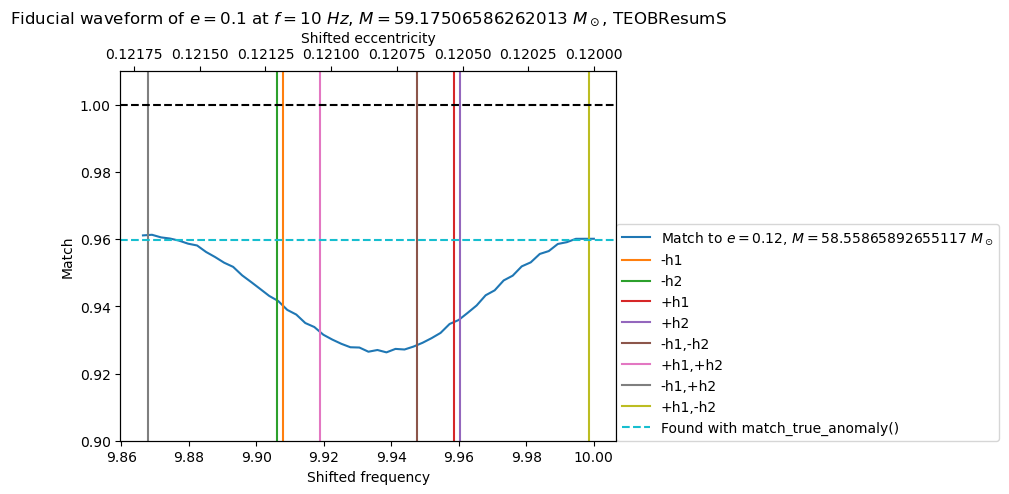

In [13]:
s = gen_wf(10, *[0.1, chirp2total(24, 2), 2], 4096, 'TEOBResumS')
m = match_true_anomaly(s, 10, 0.12, chirp2total(23.75, 2), 2, 4096, 'TEOBResumS')
plot_s_f_teob([0.1, chirp2total(24, 2), 2], (0.12, chirp2total(23.75, 2)), dataslot_4, 10, found_match=m)

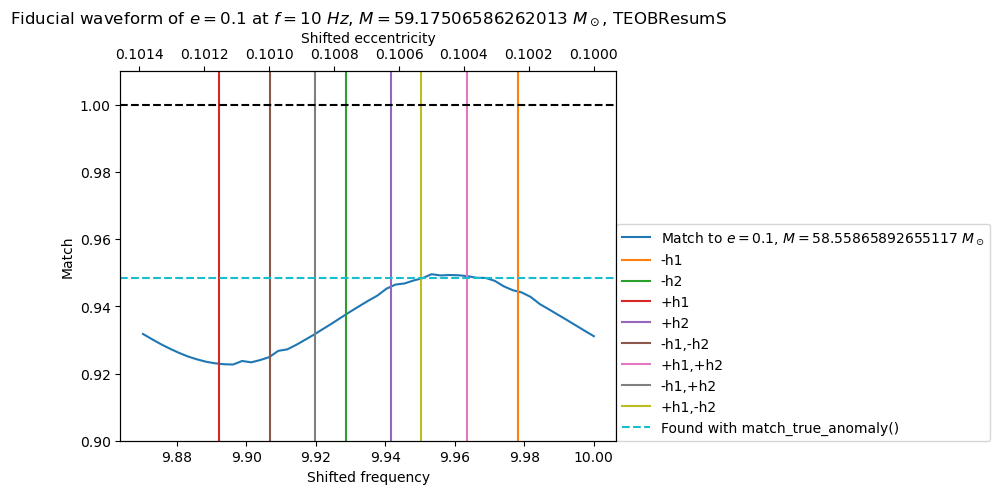

In [15]:
s = gen_wf(10, *[0.1, chirp2total(24, 2), 2], 4096, 'TEOBResumS')
m = match_true_anomaly(s, 10, 0.1, chirp2total(23.75, 2), 2, 4096, 'TEOBResumS')
plot_s_f_teob([0.1, chirp2total(24, 2), 2], (0.1, chirp2total(23.75, 2)), dataslot_5, 10, found_match=m)

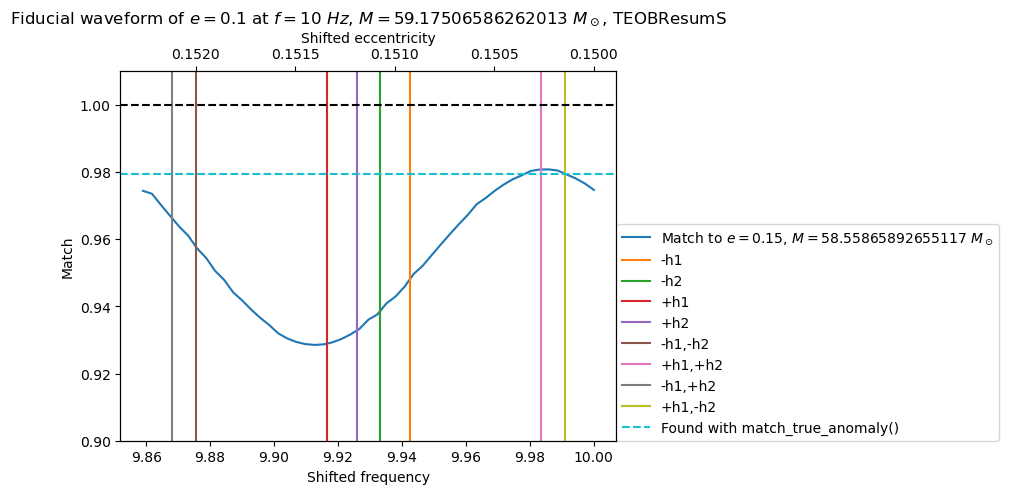

In [17]:
s = gen_wf(10, *[0.1, chirp2total(24, 2), 2], 4096, 'TEOBResumS')
m = match_true_anomaly(s, 10, 0.15, chirp2total(23.75, 2), 2, 4096, 'TEOBResumS')
plot_s_f_teob([0.1, chirp2total(24, 2), 2], (0.15, chirp2total(23.75, 2)), dataslot_6, 10, found_match=m)

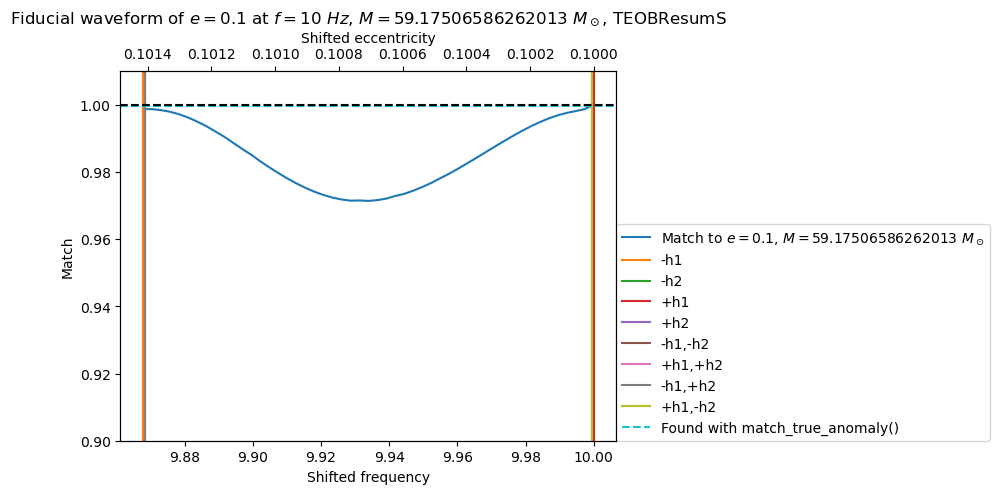

In [23]:
s = gen_wf(10, *[0.1, chirp2total(24, 2), 2], 4096, 'TEOBResumS')
m = match_true_anomaly(s, 10, 0.1, chirp2total(24, 2), 2, 4096, 'TEOBResumS')
plot_s_f_teob([0.1, chirp2total(24, 2), 2], (0.1, chirp2total(24, 2)), dataslot_7, 10, found_match=m)

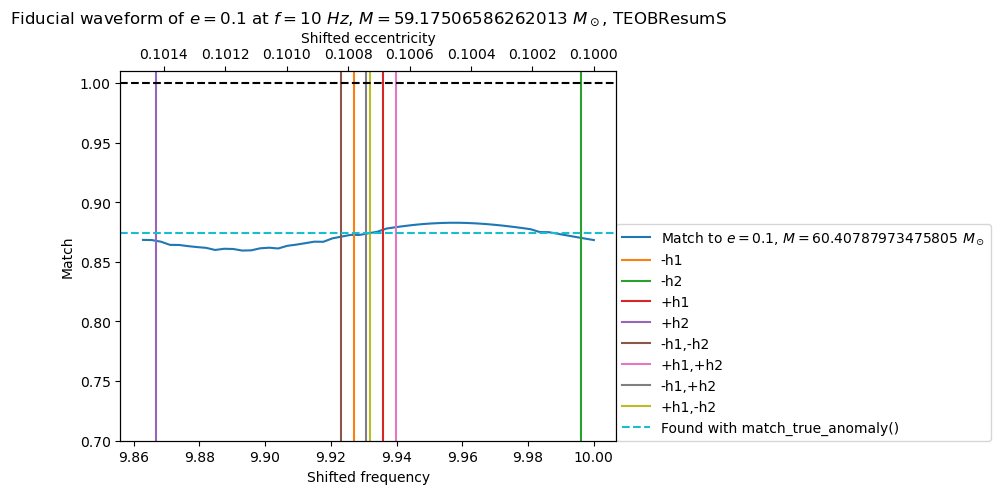

In [24]:
s = gen_wf(10, *[0.1, chirp2total(24, 2), 2], 4096, 'TEOBResumS')
m = match_true_anomaly(s, 10, 0.1, chirp2total(24.5, 2), 2, 4096, 'TEOBResumS')
plot_s_f_teob([0.1, chirp2total(24, 2), 2], (0.1, chirp2total(24.5, 2)), dataslot_8, 10, ylims=(0.7,1.01), found_match=m)

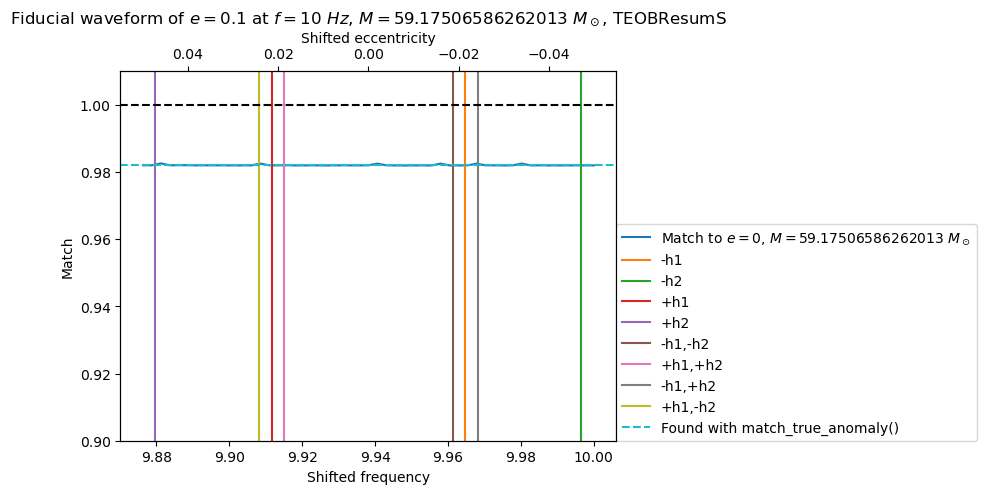

In [27]:
s = gen_wf(10, *[0.1, chirp2total(24, 2), 2], 4096, 'TEOBResumS')
m = match_true_anomaly(s, 10, 0, chirp2total(24, 2), 2, 4096, 'TEOBResumS')
plot_s_f_teob([0.1, chirp2total(24, 2), 2], (0, chirp2total(24, 2)), dataslot_9, 10, found_match=m)

# Try shifting h1, h2 forward?

In [36]:
# Calculates match over range of intial frequency values
def s_f_h1_h2_fw(fiducials, e_M, s_f_len, f_low, approximant='TEOBResumS', subsample_interpolation=True):

    # Generate fiducial waveform and data dictionary
    s = gen_wf(f_low, *fiducials, sample_rate, approximant)
    data = {}
    gridsize = s_f_len
    progress = 0
    e, M = e_M
    
    # Creates grid dimension of shifted frequency
    max_s_f = shifted_f(f_low, e, M, fiducials[2])
    s_f_vals = np.linspace(f_low, max_s_f, s_f_len, endpoint=True)
    s_e_vals = shifted_e(s_f_vals, f_low, e)
    s_f_matches_1 = []
    s_f_matches_2 = []

    # Loops over each initial frequency
    for s_f, s_e in zip(s_f_vals, s_e_vals):

        # Create waveform to match
        _, h1, h2, _, _ = get_h([1,1], s_f, s_e, M, fiducials[2], sample_rate,
                                approximant=approximant, subsample_interpolation=subsample_interpolation)

        # Calculate matches to h1 and h2
        match_h1, match_h2 = match_h1_h2(h1, h2, s, f_low)
        s_f_matches_1.append(abs(match_h1))
        s_f_matches_2.append(abs(match_h2))

        # Progress bar
        progress += 1
        print('\r' + f'{progress} done out of {gridsize}', end='')

    # Calculate total quad match of h1 and h2
    s_f_matches_quad = np.sqrt(np.array(s_f_matches_1)**2+np.array(s_f_matches_2)**2)

    # Saves data
    data['h1'] = s_f_matches_1
    data['h2'] = s_f_matches_2
    data['h_quad'] = s_f_matches_quad
    data['s_f_vals'] = s_f_vals
    data['s_e_vals'] = s_e_vals

    # Calculate phase of matches
    _, h1, h2, _, _ = get_h([1,1], f_low, e, M, fiducials[2], sample_rate,
                            approximant=approximant, subsample_interpolation=subsample_interpolation)
    match_h1, match_h2 = match_h1_h2(h1, h2, s, f_low)
    data['h1_phase'] = np.angle(match_h1)
    data['h2_phase'] = np.angle(match_h2)

    return data

In [39]:
# Shifting h1, h2 forward
start = time.time()
sample_rate = 4096
dataslot_10 = s_f_h1_h2_fw([0.1, chirp2total(24, 2), 2], (0.12, chirp2total(23.75, 2)), 51, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 240.9737708568573 seconds


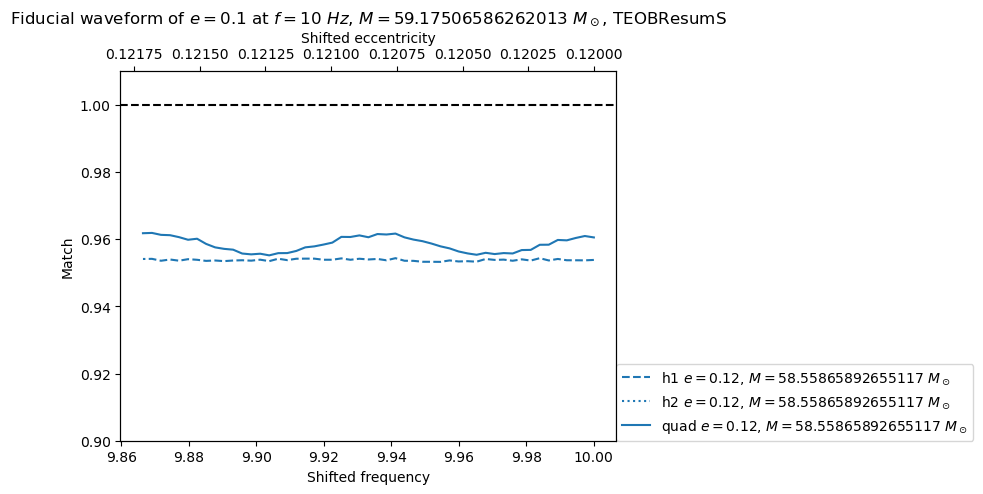

In [40]:
plot_s_f([0.1, chirp2total(24, 2), 2], (0.12, chirp2total(23.75, 2)), dataslot_10, 10, phase_lines=False) # Plot shifting h1, h2 forward

# Final match with quad match

In [44]:
start = time.time()
sample_rate = 4096
dataslot_11 = s_f_h1_h2([0.1, chirp2total(24, 2), 2], (0.12, chirp2total(23.9, 2)), 51, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 238.93109607696533 seconds


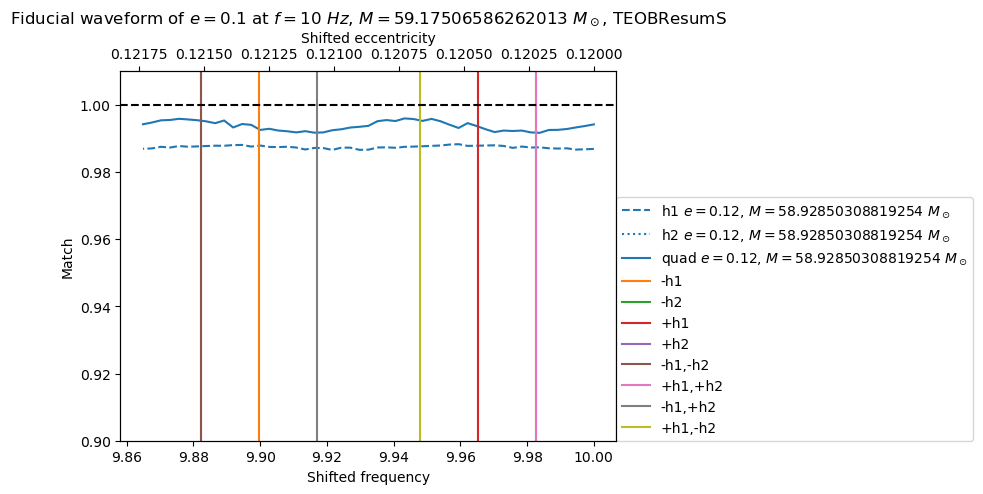

In [45]:
plot_s_f([0.1, chirp2total(24, 2), 2], (0.12, chirp2total(23.9, 2)), dataslot_11, 10)

In [46]:
start = time.time()
sample_rate = 4096
dataslot_12 = s_f_h1_h2([0.1, chirp2total(24, 2), 2], (0.19, chirp2total(23.75, 2)), 51, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 238.0169813632965 seconds


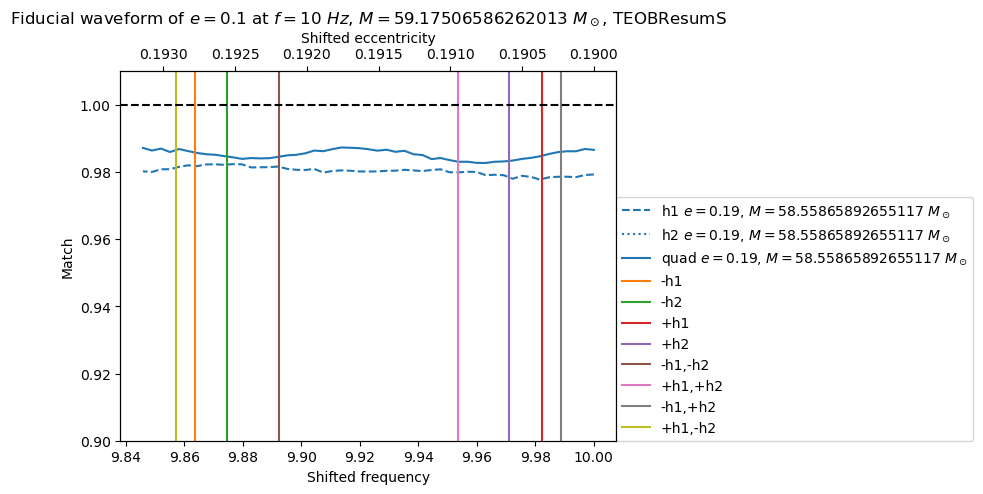

In [47]:
plot_s_f([0.1, chirp2total(24, 2), 2], (0.19, chirp2total(23.75, 2)), dataslot_12, 10)

In [48]:
start = time.time()
sample_rate = 4096
dataslot_13 = s_f_h1_h2([0.1, chirp2total(24, 2), 2], (0.1, chirp2total(24.2, 2)), 51, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 231.51788234710693 seconds


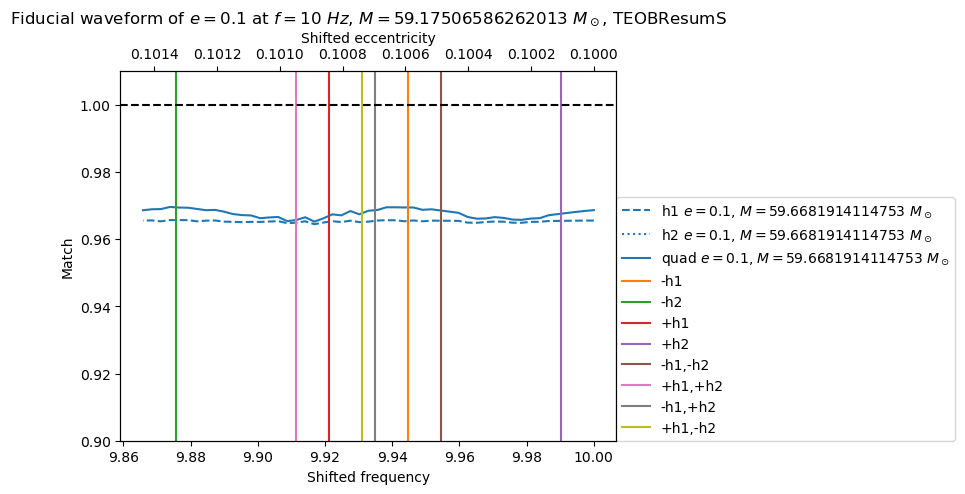

In [49]:
plot_s_f([0.1, chirp2total(24, 2), 2], (0.1, chirp2total(24.2, 2)), dataslot_13, 10)

# Testing match_true_anomaly()

In [2]:
def match_true_anomaly_test(wf_h, n, f_low, e, M, q, sample_rate, approximant, final_match):
    """
    Calculates match between two waveforms, maximised over shifted frequency 
    by calculating the true anomaly using matches to h1,...,hn waveforms.

    Parameters:
        wf_h: Fiducial waveform.
        n: Number of waveform components to use.
        f_low: Starting frequency of waveforms.
        e: Eccentricity of trial waveform.
        M: Total mass of trial waveform.
        q: Mass ratio of trial waveform.
        sample_rate: Sample rate of trial waveform.
        approximant: Approximant of trial waveform.
        final_match: Whether to perform final match to TEOBResumS waveform or h1,...,hn quad match.
        
    Returns:
        Complex match between waveforms maximised over shifted frequency/true anomaly.
    """

    # Calculates matches to h1,...,hn at f_low
    all_wfs = list(get_h([1]*n, f_low, e, M, q, sample_rate, approximant=approximant))
    matches = match_hn(all_wfs[1:n+1], wf_h, f_low)

    # Plot waveforms before for testing
    plt.plot(wf_h.sample_times, abs(wf_h), label='h wf')
    for i, wf in enumerate(all_wfs[1:3]):
        scale = np.mean(abs(wf_h[1000:10000]))/np.mean(abs(wf[1000:10000]))
        plt.plot(wf.sample_times, abs(wf)*scale, label=f'h{i+1}')
    plt.xlim(all_wfs[1].sample_times[0], all_wfs[1].sample_times[0]+2)
    plt.ylim(0*np.mean(abs(wf_h[1000:10000])), 2*np.mean(abs(wf_h[1000:10000])))
    plt.legend()
    plt.show()

    # Gets phase difference
    phase_diff = np.angle(matches[0]) - np.angle(matches[1])
    if phase_diff > 0:
        phase_diff -= 2*np.pi

    # Print phase difference for testing
    print(phase_diff)

    # Converts phase difference to shifted frequency and eccentricity
    s_f_range = f_low - shifted_f(f_low, e, M, q)
    s_f = f_low + (phase_diff/(2*np.pi))*s_f_range
    s_e = shifted_e(s_f, f_low, e)
    print(s_f, s_e)

    # Calculates match(es) to final_match at shifted frequency
    if final_match == 'TEOB':
        wf_s_f = gen_wf(s_f, s_e, M, q, sample_rate, approximant)
        m_amp, m_phase =  match_wfs(wf_s_f, wf_h, f_low, True, return_phase=True)
        match = m_amp*np.e**(1j*m_phase)
    elif final_match == 'quad':
        all_s_f_wfs = list(get_h([1]*n, s_f, s_e, M, q, sample_rate, approximant=approximant, comp_phase=-phase_diff))
        match = match_hn(all_s_f_wfs[1:n+1], wf_h, f_low)
    else:
        raise Exception('final_match not recognised')

    # Plot waveforms after for testing
    plt.plot(wf_h.sample_times, abs(wf_h), label='h wf')
    for i, wf in enumerate(all_s_f_wfs[1:3]):
        scale = np.mean(abs(wf_h[1000:10000]))/np.mean(abs(wf[1000:10000]))
        plt.plot(wf.sample_times, abs(wf)*scale, label=f'h{i+1}')
    plt.xlim(all_s_f_wfs[1].sample_times[0], all_s_f_wfs[1].sample_times[0]+2)
    plt.ylim(0*np.mean(abs(wf_h[1000:10000])), 2*np.mean(abs(wf_h[1000:10000])))
    plt.legend()
    plt.show()

    # Returns match(es)
    return match

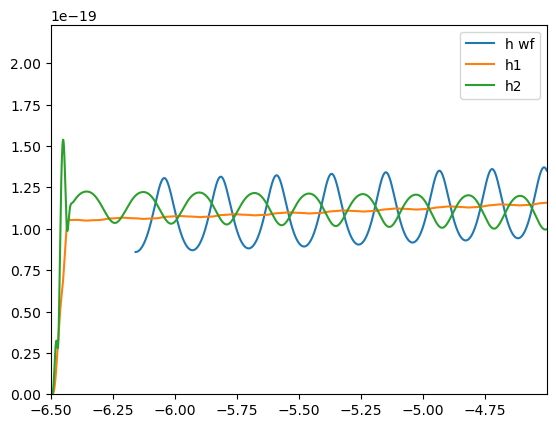

-1.547677583284856
9.967433721823578 0.10034490956692044


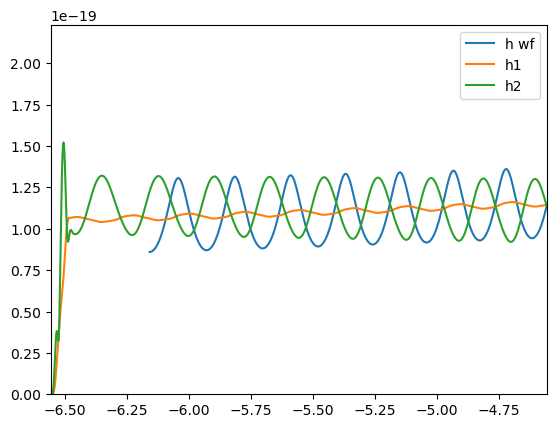

In [3]:
h = gen_wf(10, 0.15, chirp2total(24, 2), 2, 4096, 'TEOBResumS')
a = match_true_anomaly_test(h, 4, 10, 0.1, chirp2total(24, 2), 2, 4096, 'TEOBResumS', 'quad')

In [16]:
_, h1, h2, h3, h4, s1, s2, s3, s4 = get_h([1,1,1,1], 10, 0.1, chirp2total(24, 2), 2, 4096)
_, h_1, h_2, h_3, h_4, s_1, s_2, s_3, s_4 = get_h([1,1,1,1], 9.967433721823578, 0.1*(10/9.967433721823578)**(19/18), chirp2total(24, 2), 2, 4096)

(-6.0, -5.0)

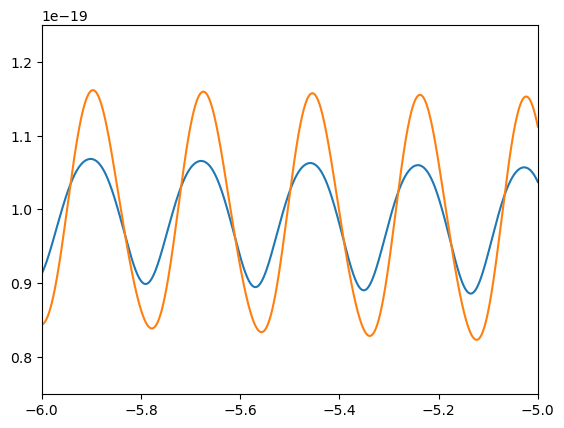

In [17]:
plt.plot(h2.sample_times, abs(h2)*4)
plt.plot(h_2.sample_times, abs(h_2)*4)
plt.ylim(0.75e-19,1.25e-19)
plt.xlim(-6,-5)

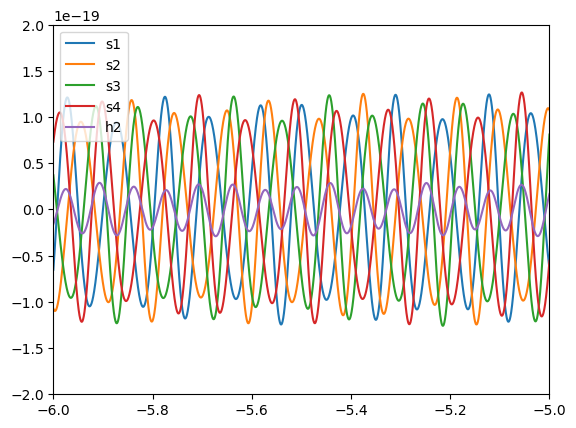

In [54]:
plt.plot(s1.sample_times, s1, label='s1')
plt.plot(s1.sample_times, 1j*s2, label='s2')
plt.plot(s1.sample_times, -s3, label='s3')
plt.plot(s1.sample_times, -1j*s4, label='s4')
plt.plot(h2.sample_times, h2, label='h2')
plt.ylim(-2e-19,2e-19)
plt.xlim(-6,-5)
plt.legend()

In [46]:
_, h1, h2, h3, h4, s1, s2, s3, s4 = get_h([1,1,1,1], 9.967433721823578, 0.1*(10/9.967433721823578)**(19/18), chirp2total(24, 2), 2, 4096)

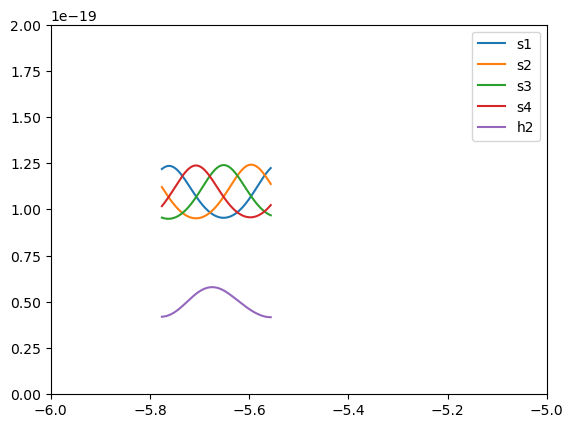

222 230 227
229 227 221


In [50]:
inds = [3200,4100]
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s1[inds[0]:inds[1]]), label='s1')
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s2[inds[0]:inds[1]]), label='s2')
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s3[inds[0]:inds[1]]), label='s3')
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s4[inds[0]:inds[1]]), label='s4')
plt.plot(h2.sample_times[inds[0]:inds[1]], abs(h2[inds[0]:inds[1]])*2, label='h2')
plt.ylim(0e-19,2e-19)
plt.xlim(-6,-5)
plt.legend()
plt.show()

peak1_ind = np.argmax(abs(s1[inds[0]:inds[1]]))
peak2_ind = np.argmax(abs(s2[inds[0]:inds[1]]))
peak3_ind = np.argmax(abs(s3[inds[0]:inds[1]]))
peak4_ind = np.argmax(abs(s4[inds[0]:inds[1]]))
min1_ind = np.argmin(abs(s1[inds[0]:inds[1]]))
min2_ind = np.argmin(abs(s2[inds[0]:inds[1]]))
min3_ind = np.argmin(abs(s3[inds[0]:inds[1]]))
min4_ind = np.argmin(abs(s4[inds[0]:inds[1]]))
print(peak4_ind - peak1_ind, peak3_ind - peak4_ind, peak2_ind - peak3_ind)
print(min2_ind - min3_ind, min1_ind - min2_ind, min4_ind - min1_ind)

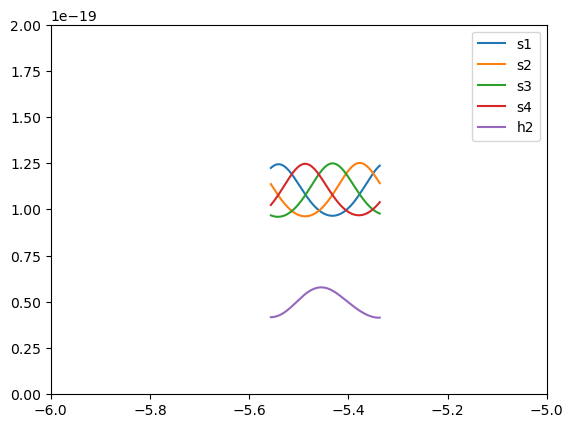

219 227 224
226 224 218


In [51]:
inds = [4100,5000]
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s1[inds[0]:inds[1]]), label='s1')
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s2[inds[0]:inds[1]]), label='s2')
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s3[inds[0]:inds[1]]), label='s3')
plt.plot(s1.sample_times[inds[0]:inds[1]], abs(s4[inds[0]:inds[1]]), label='s4')
plt.plot(h2.sample_times[inds[0]:inds[1]], abs(h2[inds[0]:inds[1]])*2, label='h2')
plt.ylim(0e-19,2e-19)
plt.xlim(-6,-5)
plt.legend()
plt.show()

peak1_ind = np.argmax(abs(s1[inds[0]:inds[1]]))
peak2_ind = np.argmax(abs(s2[inds[0]:inds[1]]))
peak3_ind = np.argmax(abs(s3[inds[0]:inds[1]]))
peak4_ind = np.argmax(abs(s4[inds[0]:inds[1]]))
min1_ind = np.argmin(abs(s1[inds[0]:inds[1]]))
min2_ind = np.argmin(abs(s2[inds[0]:inds[1]]))
min3_ind = np.argmin(abs(s3[inds[0]:inds[1]]))
min4_ind = np.argmin(abs(s4[inds[0]:inds[1]]))
print(peak4_ind - peak1_ind, peak3_ind - peak4_ind, peak2_ind - peak3_ind)
print(min2_ind - min3_ind, min1_ind - min2_ind, min4_ind - min1_ind)